# Lab 4 - Linear models

We focus on models in the form 

$$ y ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

or in generalized form (generalized linear models)

$$ f(y) ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

where $f(y)$ is a link function, for example - logit.


In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)
print(sim.draws_pd())

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: E:/Programowanie/Microsoft VS Code Projects/Data Analytics/Lab_4/height_1_ppc.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


     lp__  accept_stat__       mu      sigma   height
0     0.0            0.0  232.163   8.126140  217.968
1     0.0            0.0  188.640  70.331700  297.765
2     0.0            0.0  170.755  11.778900  178.482
3     0.0            0.0  182.602  19.518000  217.971
4     0.0            0.0  152.394   4.678490  159.762
..    ...            ...      ...        ...      ...
995   0.0            0.0  178.704   0.038448  178.692
996   0.0            0.0  172.086   5.345250  171.941
997   0.0            0.0  188.423  12.742400  183.248
998   0.0            0.0  154.132   4.810070  151.071
999   0.0            0.0  175.975   1.305590  175.987

[1000 rows x 5 columns]


#### Task 1. Prior predictive checks

1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors
4. Check if observed data is possible to obtain using priors.

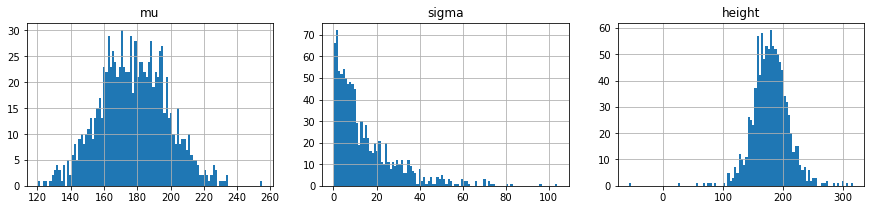

In [4]:
df_mu = pd.DataFrame(sim.stan_variables()["mu"])
df_sigma = pd.DataFrame(sim.stan_variables()["sigma"])
df_height = pd.DataFrame(sim.stan_variables()["height"])

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 3)
axs[0].hist(df_mu, bins=100)
axs[0].grid()
axs[0].set_title('mu')
axs[1].hist(df_sigma, bins=100)
axs[1].grid()
axs[1].set_title('sigma')
axs[2].hist(df_height, bins=100)
axs[2].grid()
axs[2].set_title('height')
plt.show()


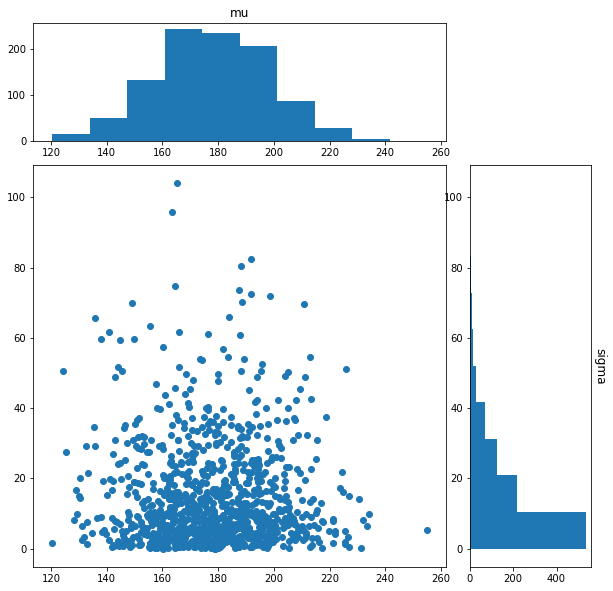

In [5]:
from matplotlib.gridspec import GridSpec

fig = plt.figure()
fig.set_size_inches(10, 10)
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(df_mu, df_sigma)
ax_hist_x.hist(df_mu)
ax_hist_x.set_title('mu')
ax_hist_y.hist(df_sigma, orientation = 'horizontal')
ax_hist_y.set_ylabel('sigma', rotation=-90, fontsize=12, labelpad=15)
ax_hist_y.yaxis.set_label_position("right")
plt.show()

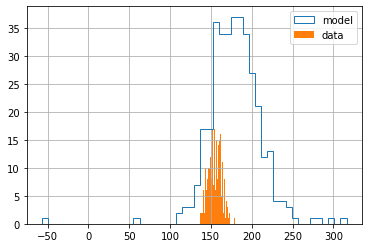

In [6]:
plt.figure()
plt.hist(df_height[:352],bins=50,histtype='step')
plt.hist(d['height'],bins=50)
plt.legend(["model", "data"])
plt.grid()
plt.show()

In [7]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: E:/Programowanie/Microsoft VS Code Projects/Data Analytics/Lab_4/height_1_fit.exe


In [8]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


#### Task 2. Model fit and evaluation

1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.



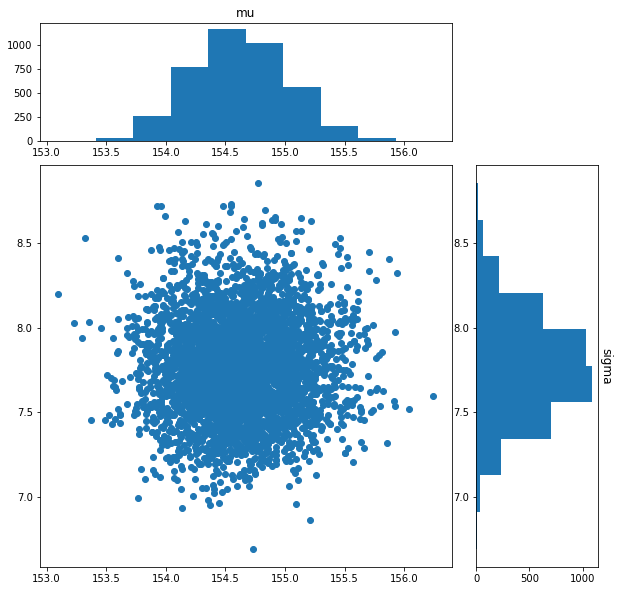

In [9]:
df_mu = pd.DataFrame(fit.stan_variables()["mu"])
df_sigma = pd.DataFrame(fit.stan_variables()["sigma"])
df_height = pd.DataFrame(fit.stan_variables()["height"])

fig = plt.figure()
fig.set_size_inches(10, 10)
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(df_mu, df_sigma)
ax_hist_x.hist(df_mu)
ax_hist_x.set_title('mu')
ax_hist_y.hist(df_sigma, orientation = 'horizontal')
ax_hist_y.set_ylabel('sigma', rotation=-90, fontsize=12, labelpad=15)
ax_hist_y.yaxis.set_label_position("right")
plt.show()

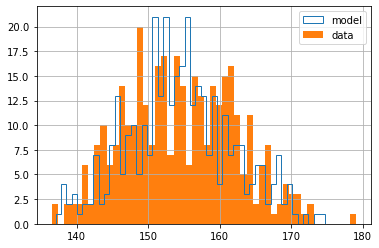

In [10]:
plt.figure()
plt.hist(df_height[:352],bins=50,histtype='step')
plt.hist(d['height'],bins=50)
plt.legend(["model", "data"])
plt.grid()
plt.show()

### Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [11]:
d['c_weight'] = d['weight'] - d['weight'].mean()

model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

print(sim.draws_pd())

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: E:/Programowanie/Microsoft VS Code Projects/Data Analytics/Lab_4/height_2a_ppc.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


     lp__  accept_stat__    alpha       beta      sigma  height[1]  height[2]  \
0     0.0            0.0  232.163   7.771810  23.208300  375.03300   339.8260   
1     0.0            0.0  154.022  -0.067795   0.086958  152.90700   152.8670   
2     0.0            0.0  169.461 -11.386400  20.358900   -6.68039   -39.3503   
3     0.0            0.0  158.357  -2.544520   6.415610  121.07700   108.3180   
4     0.0            0.0  158.131  16.710200   9.955320  432.96300   453.0610   
..    ...            ...      ...        ...        ...        ...        ...   
995   0.0            0.0  161.753  12.613000   6.017940  394.74900   379.2080   
996   0.0            0.0  196.362  12.233800  10.413300  423.57600   423.0860   
997   0.0            0.0  172.792  -2.720510  76.805200   86.40090   219.9450   
998   0.0            0.0  126.115   9.871600  23.204300  324.56000   309.4040   
999   0.0            0.0  203.609  -5.146610  12.390200  106.24500   101.3280   

     height[3]  height[4]  

#### Task 4. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (272 cm) heights observed in nature.

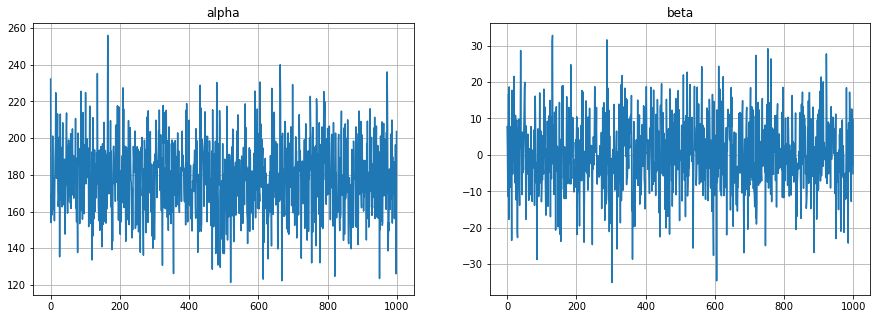

In [12]:
df_alpha = pd.DataFrame(sim.stan_variables()["alpha"])
df_beta = pd.DataFrame(sim.stan_variables()["beta"])

fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 5)
axs[0].plot(df_alpha)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(df_beta)
axs[1].grid()
axs[1].set_title('beta')
plt.show()

### Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [13]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: E:/Programowanie/Microsoft VS Code Projects/Data Analytics/Lab_4/height_2b_ppc.exe


In [14]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

print(sim.draws_pd())

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


     lp__  accept_stat__    alpha      beta      sigma  height[1]  height[2]  \
0     0.0            0.0  232.163  2.175330  23.208300    274.285    239.078   
1     0.0            0.0  154.022  0.993243   0.086958    172.008    171.968   
2     0.0            0.0  169.461  0.320255  20.358900    204.064    171.394   
3     0.0            0.0  158.357  0.775342   6.415610    180.842    168.082   
4     0.0            0.0  158.131  5.317560   9.955320    227.872    247.971   
..    ...            ...      ...       ...        ...        ...        ...   
995   0.0            0.0  161.753  3.529990   6.017940    231.237    215.696   
996   0.0            0.0  196.362  3.398650  10.413300    264.525    264.035   
997   0.0            0.0  172.792  0.761815  76.805200    149.090    282.634   
998   0.0            0.0  126.115  2.683600  23.204300    195.160    180.005   
999   0.0            0.0  203.609  0.597703  12.390200    209.655    204.738   

     height[3]  height[4]  height[5]  .

#### Task 5. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (272 cm) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

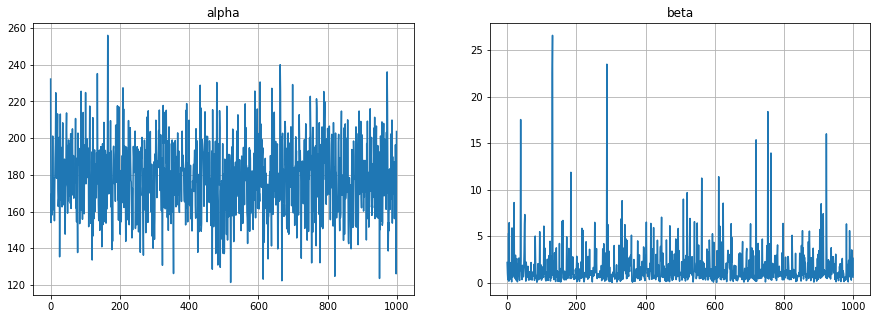

In [15]:
df_alpha = pd.DataFrame(sim.stan_variables()["alpha"])
df_beta = pd.DataFrame(sim.stan_variables()["beta"])

fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 5)
axs[0].plot(df_alpha)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(df_beta)
axs[1].grid()
axs[1].set_title('beta')
plt.show()

<AxesSubplot:>

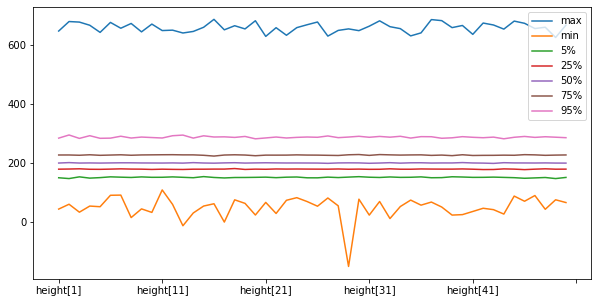

In [16]:
data = sim.draws_pd()
heights = data[data.columns[5:]]

quans = pd.DataFrame({'max': heights.max(), 'min': heights.min(), '5%': heights.quantile(0.05), '25%': heights.quantile(0.25), '50%': heights.quantile(0.5), '75%': heights.quantile(0.75), '95%': heights.quantile(0.95)})
quans.plot(figsize=(10,5))


### Fitting data


In [17]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: E:/Programowanie/Microsoft VS Code Projects/Data Analytics/Lab_4/height_2_fit.exe


#### Task 6. Preparing data for fit
1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe

In [18]:
n = 50
data_fit = {
    "N": n,
    "weight": d["weight"][:n].tolist(),
    "heights": d["height"][:n].tolist()
}

fit = model_2_fit.sample(data=data_fit,seed=28052020)

print(fit.draws_pd())


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -109.899       0.998539    0.104787          5.0          31.0   
1    -111.450       0.811565    0.104787          5.0          31.0   
2    -109.576       0.948816    0.104787          5.0          31.0   
3    -110.495       0.770003    0.104787          3.0          15.0   
4    -109.910       0.971714    0.104787          4.0          19.0   
...       ...            ...         ...          ...           ...   
3995 -108.587       0.996287    0.114474          2.0           7.0   
3996 -108.560       0.999770    0.114474          5.0          31.0   
3997 -109.270       0.832161    0.114474          4.0          23.0   
3998 -108.814       0.991084    0.114474          4.0          19.0   
3999 -108.586       0.999417    0.114474          4.0          31.0   

      divergent__  energy__    alpha      beta    sigma  ...  height[41]  \
0             0.0   111.360  120.787  0.714021  5.91460  ...     166.47

#### Task 7. Evaluating model

1. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


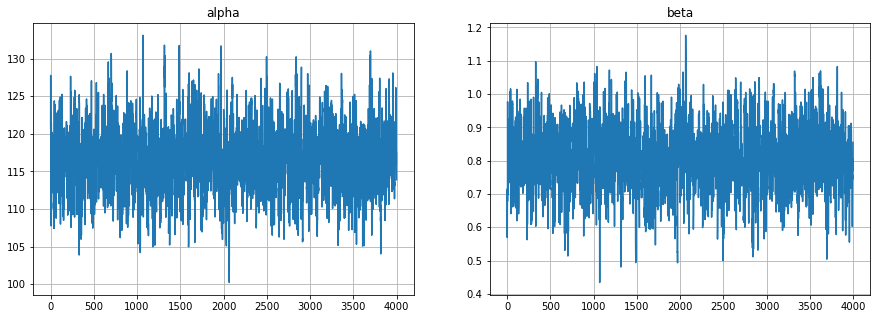

In [19]:
df_alpha = pd.DataFrame(fit.stan_variables()["alpha"])
df_beta = pd.DataFrame(fit.stan_variables()["beta"])

fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 5)
axs[0].plot(df_alpha)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(df_beta)
axs[1].grid()
axs[1].set_title('beta')
plt.show()

<AxesSubplot:>

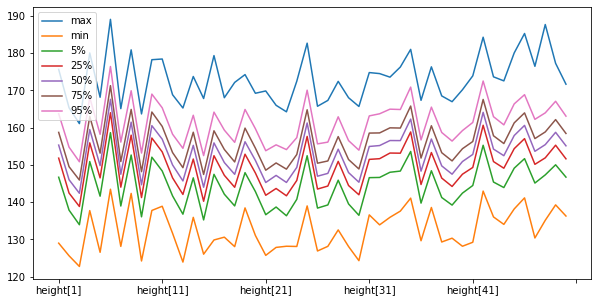

In [20]:
data = fit.draws_pd()
heights = data[data.columns[60:]]

quans = pd.DataFrame({'max': heights.max(), 'min': heights.min(), '5%': heights.quantile(0.05), '25%': heights.quantile(0.25), '50%': heights.quantile(0.5), '75%': heights.quantile(0.75), '95%': heights.quantile(0.95)})
quans.plot(figsize=(10,5))